In [1]:
"""
Created on Tue Mar  7 17:52:41 2017

@author: Biagio Brattoli
"""
import numpy as np
import matplotlib.pyplot as plt
from time import time

from sklearn.manifold import TSNE
import tensorflow as tf

/export/home/bbrattol/anaconda/envs/tensorflow_cpu/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
D = 100

# Generate 3 gaussian distribution with dimensionality D
points_A = np.random.normal(loc=np.random.randn(D),scale=1.0,size=(1200,D))
points_B = np.random.normal(loc=np.random.randn(D),scale=1.1,size=(1200,D))
points_C = np.random.normal(loc=np.random.randn(D),scale=1.2,size=(1200,D))

In [3]:
# Split train/test
train_A = points_A[0:1000,:]
test_A  = points_A[1000:,:]
train_B = points_B[0:1000,:]
test_B  = points_B[1000:,:]
train_C = points_C[0:1000,:]
test_C  = points_C[1000:,:]

train_X = np.concatenate([train_A,train_B,train_C],axis=0)

test_X = np.concatenate([test_A,test_B,test_C],axis=0)
test_class = np.concatenate([0*np.ones(test_A.shape[0]),
                         0.01*np.ones(test_B.shape[0]),
                         0.02*np.ones(test_C.shape[0])],axis=0)

In [4]:
# Reduce dimensionality using TSNE: this will be our label
model = TSNE(n_components=2, random_state=1278)
y = model.fit_transform(np.concatenate([train_X,test_X],axis=0))
train_y = y[0:3000,:]
test_y = y[3000:,:]

In [5]:
# Network definition
def rand_var(shape):
    return tf.truncated_normal(shape, stddev=0.01)

def const_var(shape):
    return tf.constant(0.1, shape=shape)

with tf.variable_scope('input'):
    x = tf.placeholder(tf.float32, (None,D), name='x')
    y = tf.placeholder(tf.float32, (None,2), name='y')

with tf.variable_scope('layer1'):
    h1_w = tf.Variable(rand_var((int(x.get_shape()[1]),64)), name='weight', trainable=True)
    h1_b = tf.Variable(const_var((64,)), name='bias', trainable=True)
    h1 = tf.add(tf.matmul(x,h1_w),h1_b, name='h1')

with tf.variable_scope('output'):
    out_w = tf.Variable(rand_var((int(h1.get_shape()[1]),2)), name='weight', trainable=True)
    out_b = tf.Variable(const_var((2,)), name='bias', trainable=True)
    out = tf.add(tf.matmul(h1,out_w),out_b, name='out')

In [6]:
# Start session
graph = tf.get_default_graph()
config = tf.ConfigProto(log_device_placement=False,
                        allow_soft_placement=True)
config.gpu_options.per_process_gpu_memory_fraction = 0.3

sess = tf.Session(config=config)

In [7]:
# Loss definition
cost = tf.reduce_mean(tf.nn.l2_loss(out-y))
train_op = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)

In [8]:
sess.run(tf.global_variables_initializer())

In [9]:
# Train
N = train_X.shape[0]
batch_size = 100
B = N/batch_size

p = np.random.permutation(N)
train_X = train_X[p,:]
train_y = train_y[p]

In [10]:
# Keep track of testing during training
y_pred_iter = []

# Test with random initialization
y_pred = sess.run(out, feed_dict={x: test_X})
y_pred_iter.append(y_pred)

In [11]:
t1 = time()
for ii in xrange(8):
    batch_idx = ii%B
    # fill data for training
    feed_dict_train = {x: train_X[batch_size*batch_idx:batch_size*(batch_idx+1)],
                       y: train_y[batch_size*batch_idx:batch_size*(batch_idx+1)]}
    
    # training
    _,loss = sess.run([train_op,cost], feed_dict=feed_dict_train)
    print 'Iter %d, Loss=%.3f done in %.3f'%(ii,loss,time()-t1)
    
    # testing
    y_pred_iter.append(sess.run(out, feed_dict={x: test_X}))

Iter 0, Loss=2512.798 done in 0.010
Iter 1, Loss=2406.172 done in 0.013
Iter 2, Loss=2075.567 done in 0.016
Iter 3, Loss=2327.371 done in 0.018
Iter 4, Loss=2324.082 done in 0.021
Iter 5, Loss=2611.287 done in 0.025
Iter 6, Loss=2086.426 done in 0.033
Iter 7, Loss=2245.359 done in 0.036


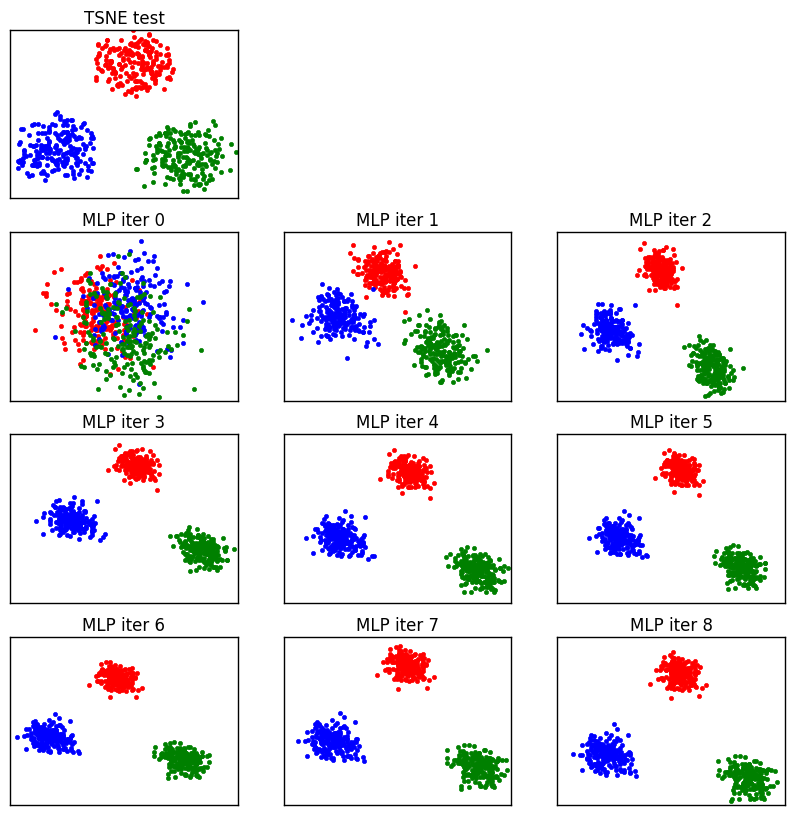

In [13]:
# Plot testing during training
plt.figure(figsize=(10,10))
plt.subplot(4,3,1)
plt.hold('On')
plt.plot(test_y[0:200,0],test_y[0:200,1],'.r')
plt.plot(test_y[200:400,0],test_y[200:400,1],'.b')
plt.plot(test_y[400:600,0],test_y[400:600,1],'.g')
plt.title('TSNE test')
plt.xticks([], [])
plt.yticks([], [])

for i in range(len(y_pred_iter)):
    y_pred = y_pred_iter[i]
    plt.subplot(4,3,i+4)
    plt.hold('On')
    plt.plot(y_pred[0:200,0],y_pred[0:200,1],'.r')
    plt.plot(y_pred[200:400,0],y_pred[200:400,1],'.b')
    plt.plot(y_pred[400:600,0],y_pred[400:600,1],'.g')
    plt.title('MLP iter %d'%(i))
    plt.xticks([], [])
    plt.yticks([], [])

plt.show()